# Phenology in S2 NDVI



**Prerequisites**
* In this notebook we are using openEO to fetch the time series data for the meadow. You can register for a free trial account on the [openEO Platform](https://openeo.cloud/#plans) website.

Lets start with importing the different libraries that we need within this notebook.

In [17]:
import os
import sys

# Add local version of FuseTS
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)


import numpy as np
import openeo
import xarray
from fusets.analytics import phenology
from fusets.whittaker import whittaker

import matplotlib.pyplot as plt
import datetime

### Downloading the S2 time series
In order to execute the peak valley algorithm, we need to have time series data. Retrieving time series data can be done through various methods, and one such method is using openEO. [OpenEO](https://openeo.org/) is an API that provides access to a variety of Earth Observation (EO) data and processing services in a standardized and easy-to-use way. By leveraging the power of openEO, we can easily retrieve the time series data for the meadow and use it to analyze the patterns and trends.

More information on the usage of openEO's Python client can be found on [GitHub](https://github.com/Open-EO/openeo-python-client).

The first step is to connect to an openEO compatible backend.

In [2]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


Next we define the area of interest, in this case an extent, for which we would like to fetch time series data.

In [3]:
year = 2022
spat_ext =  {
        "coordinates": [
          [
            [
              5.179169745059369,
              51.24984286550534
            ],
            [
              5.170016107999743,
              51.25052999567865
            ],
            [
              5.171081610725707,
              51.24861004739975
            ],
            [
              5.178604705735125,
              51.246720335821465
            ],
            [
              5.179169745059369,
              51.24984286550534
            ]
          ]
        ],
        "type": "Polygon"
      }
temp_ext = [f"{year}-05-01", f"{year}-09-30"]

We will create an openEO process to calculate the NDVI time series for our area of interest. We'll begin by using the SENTINEL2_L2A_SENTINELHUB collection, and apply a cloud masking algorithm to remove any interfering clouds before calculating the NDVI values.

In [4]:
s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
s2 = s2.mask_polygon(spat_ext)
ndvi_cube = s2.ndvi(red="B04", nir="B08", target_band='NDVI')

Now that we have calculated the NDVI time series for our area of interest, we can request openEO to download the result to our local storage. This will allow us to access the file and use it for further analysis in this notebook. However, if we have already downloaded the file, we can use the existing time series to continue our analysis without the need for a new download.

In [26]:
if not os.path.exists('./s2_field.nc'):
    job = ndvi_cube.execute_batch("s2_field.nc", title=f'AI4FOOD - Phenology - Time Series', out_format="netCDF")

ds = xarray.load_dataset('./s2_field.nc')
ndvi = ds.NDVI.rename({'t': 'time'})

Now that we have calculated the NDVI time series, we can utilize it to execute the peak valley algorithm that is part of the FuseTS algorithm. The peak valley algorithm is a powerful tool that allows us to detect significant changes in the vegetation patterns over time. 

In [27]:
ndvi_smoothed = whittaker(ndvi, smoothing_lambda=5000)
phenology_result = phenology(ndvi_smoothed)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

In [34]:
average_ndvi = ndvi_smoothed.median(dim=['x', 'y'])

sos = phenology_result.sos_times.median(dim=['x', 'y']).values.take(0)
pos = phenology_result.pos_times.median(dim=['x', 'y']).values.take(0)
eos = phenology_result.eos_times.median(dim=['x', 'y']).values.take(0)

sos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=sos)
pos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=pos)
eos_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=eos)

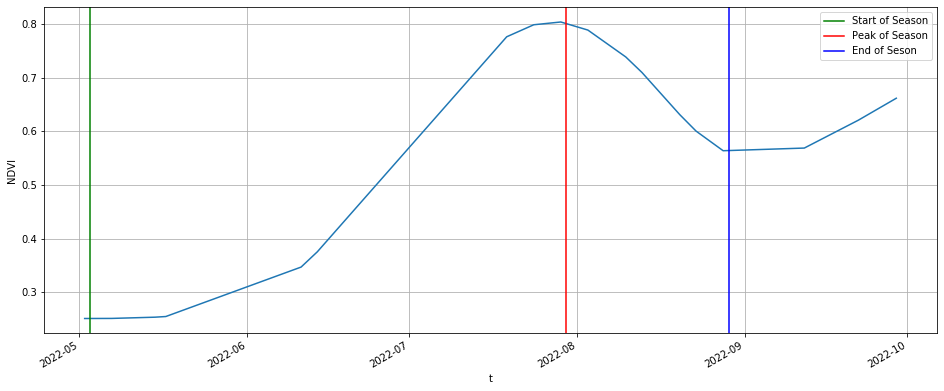

In [35]:
plt.figure(figsize= (16,6))
average_ndvi.plot()
plt.ylabel ('NDVI')
plt.axvline(x = sos_date, color = 'g', label = 'Start of Season')
plt.axvline(x = pos_date, color = 'r', label = 'Peak of Season')
plt.axvline(x = eos_date, color = 'b', label = 'End of Seson')
plt.grid(True)
plt.legend()